In [123]:
import pandas as pd, numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, f1_score, precision_score, recall_score, explained_variance_score, mean_absolute_error
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import bootstrap
import copy
import warnings
warnings.filterwarnings("ignore")

sns.set()

In [87]:
dfs = dict(methylnet=dict(),other=dict())
dfs['methylnet']['pancancer'] = pd.read_csv('methylnet-pancancer_results.csv',index_col=0)
dfs['methylnet']['cell'] = pd.read_csv('methylnet-cell-type-results.csv',index_col=0)
dfs['methylnet']['age'] = pd.read_csv('methylnet-age-results.csv',index_col=0)
dfs['other']['pancancer'] = pd.read_csv('svm-pancancer_sklearn_predictions.csv',index_col=0)
dfs['other']['cell'] = pd.read_csv('EpiDISH-cell-type-results.csv',index_col=0)
dfs['other']['age'] = pd.read_csv('cgage-age-results.csv',index_col=0)
one_hot_encoder = pickle.load(open('one_hot_encoder.p','rb'))

In [91]:
lb=LabelBinarizer()
dfs['methylnet']['pancancer'].loc[:,'y_true'] = one_hot_encoder.inverse_transform(lb.fit_transform(dfs['methylnet']['pancancer'].loc[:,'y_true']))
dfs['methylnet']['pancancer'].loc[:,'y_pred'] = one_hot_encoder.inverse_transform(lb.transform(dfs['methylnet']['pancancer'].loc[:,'y_pred']))



In [92]:
normalize=True
labels=dfs['methylnet']['pancancer'].loc[:,'y_true'].unique()

confusion=np.array(confusion_matrix(dfs['methylnet']['pancancer'].loc[:,'y_true'],dfs['methylnet']['pancancer'].loc[:,'y_pred'],labels=labels))
print(confusion)
if normalize:
    confusion=confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
confusion=pd.DataFrame(confusion,index=labels,columns=labels).T




[[ 14   0   0 ...   0   0   0]
 [  0  74   0 ...   0   0   0]
 [  0   0 149 ...   0   0   0]
 ...
 [  0   0   1 ...  84   0   0]
 [  0   0   0 ...   0   9   0]
 [  0   0   0 ...   0   0  13]]


In [93]:
if not normalize:
    confusion.to_csv('pancancer-confusion-matrix.csv')

Text(111.5, 0.5, 'Predicted Label')

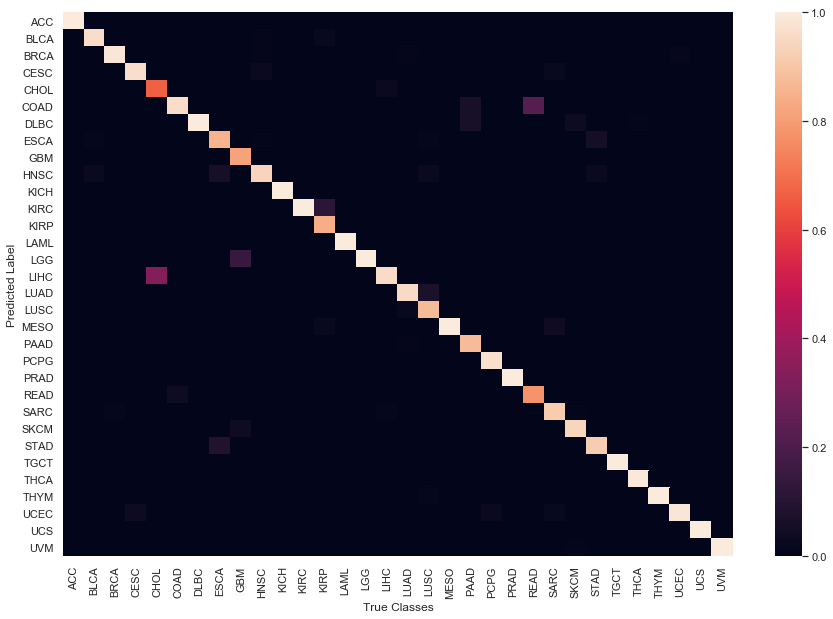

In [94]:
plt.figure(figsize=(15,10))
sns.heatmap(confusion)
plt.xlabel('True Classes')
plt.ylabel('Predicted Label')

In [125]:
average_mechanism='weighted'

def extract_ys(Y):
    return Y[:,0], Y[:,1]

def r2(Y):
    y_true, y_pred=extract_ys(Y)
    return r2_score(y_true, y_pred)

def mae(Y):
    y_true, y_pred=extract_ys(Y)
    return mean_absolute_error(y_true, y_pred)

def explained_variance(Y):
    y_true, y_pred=extract_ys(Y)
    return explained_variance_score(y_true, y_pred)

def accuracy(Y):
    y_true, y_pred=extract_ys(Y)
    return accuracy_score(y_true, y_pred)

def recall(Y):
    y_true, y_pred=extract_ys(Y)
    return recall_score(y_true, y_pred, average=average_mechanism)

def precision(Y):
    y_true, y_pred=extract_ys(Y)
    return precision_score(y_true, y_pred, average=average_mechanism)

def f1(Y):
    y_true, y_pred=extract_ys(Y)
    return f1_score(y_true, y_pred, average=average_mechanism)

In [133]:
for k1 in dfs:
    for k2 in dfs[k1]:
        print(k1,k2,list(dfs[k1][k2]))
        
print(dfs['other']['cell']['Est_Method'].unique())
classification_fn = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1}
regression_fn = {'r2':r2, 'mae':mae, 'explained_variance':explained_variance}

methylnet pancancer ['y_pred', 'y_true']
methylnet cell ['Bcell_pred', 'CD4T_pred', 'CD8T_pred', 'Mono_pred', 'NK_pred', 'Neu_pred', 'Bcell_true', 'CD4T_true', 'CD8T_true', 'Mono_true', 'NK_true', 'Neu_true']
methylnet age ['Age_pred', 'Age_true']
other pancancer ['y_pred', 'y_true']
other cell ['CD8T', 'CD4T', 'NK', 'Bcell', 'Mono', 'Neu', 'Est_Method']
other age ['Hannum.Est', 'EpiTOC.Est', 'Horvath.Est']
['Robust Partial Correlations' 'Cibersort' 'Constrained Projection']


In [157]:
def return_bootstrap_results(Y,fn):
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    return "{}±{}".format(round(original,4),round(std_err,4))

In [166]:
cell_types = list(dfs['other']['cell'])[:-1]
results = {'Pancancer':{'MethylNet':[],'UMAP+SVM':[]},
          'Cell-Type Deconvolution':{'MethylNet':{k:[] for k in cell_types},'EpiDISH+RPC':{k:[] for k in cell_types},'EpiDISH+Cibersort':{k:[] for k in cell_types},'EpiDISH+CP':{k:[] for k in cell_types}},
          'Age Prediction':{'MethylNet':[],'Hannum Clock':[],'Horvath Clock':[]}}



In [172]:
le=LabelEncoder()
dfs['methylnet']['pancancer'].loc[:,'y_true'] = le.fit_transform(dfs['methylnet']['pancancer'].loc[:,'y_true'])
dfs['methylnet']['pancancer'].loc[:,'y_pred'] = le.transform(dfs['methylnet']['pancancer'].loc[:,'y_pred'])


In [173]:
results['Pancancer']['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['pancancer'].iloc[:,::-1].values,classification_fn[fn]) for fn in classification_fn.keys()}

In [174]:
le=LabelEncoder()
dfs['other']['pancancer'].loc[:,'y_true'] = le.fit_transform(dfs['other']['pancancer'].loc[:,'y_true'])
dfs['other']['pancancer'].loc[:,'y_pred'] = le.transform(dfs['other']['pancancer'].loc[:,'y_pred'])

In [175]:
results['Pancancer']['UMAP+SVM']={fn:return_bootstrap_results(dfs['other']['pancancer'].iloc[:,::-1].values,classification_fn[fn]) for fn in classification_fn.keys()}



In [170]:
for cell in cell_types:
    results['Cell-Type Deconvolution']['MethylNet'][cell]={fn:return_bootstrap_results(dfs['methylnet']['cell'][[col for col in list(dfs['methylnet']['cell']) if col.startswith(cell)]].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
 


In [168]:
analysis_dict = {'Robust Partial Correlations':'RPC', 'Cibersort':'Cibersort', 'Constrained Projection':'CP'}
for name,dff in dfs['other']['cell'].groupby('Est_Method'):
    for cell in cell_types:
        Y=pd.concat([pd.DataFrame(dfs['methylnet']['cell']['{}_true'.format(cell)]),pd.DataFrame(dff[cell])],axis=1).values
        results['Cell-Type Deconvolution']['EpiDISH+{}'.format(analysis_dict[name])][cell]={fn:return_bootstrap_results(Y,regression_fn[fn]) for fn in regression_fn.keys()}

In [178]:
results['Age Prediction']['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['age'].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
for clock in ['Hannum','Horvath']:
    results['Age Prediction']['{} Clock'.format(clock)]={fn:return_bootstrap_results(pd.concat([pd.DataFrame(dfs['methylnet']['age']['Age_true']),pd.DataFrame(dfs['other']['age']['{}.Est'.format(clock)])],axis=1).values,regression_fn[fn]) for fn in regression_fn.keys()}
    


In [176]:
results

{'Pancancer': {'MethylNet': {'accuracy': '0.9553±0.0052',
   'recall': '0.9553±0.0052',
   'precision': '0.9579±0.0048',
   'f1': '0.9555±0.0052'},
  'UMAP+SVM': {'accuracy': '0.8389±0.0091',
   'recall': '0.8389±0.0091',
   'precision': '0.8136±0.0103',
   'f1': '0.8228±0.0098'}},
 'Cell-Type Deconvolution': {'MethylNet': {'CD8T': {'r2': '0.7776±0.0402',
    'mae': '0.0161±0.0012',
    'explained_variance': '0.7807±0.0378'},
   'CD4T': {'r2': '0.8636±0.0177',
    'mae': '0.0141±0.0009',
    'explained_variance': '0.8757±0.0164'},
   'NK': {'r2': '0.8676±0.0174',
    'mae': '0.0122±0.0009',
    'explained_variance': '0.8692±0.0169'},
   'Bcell': {'r2': '0.787±0.026',
    'mae': '0.009±0.0006',
    'explained_variance': '0.789±0.0253'},
   'Mono': {'r2': '0.3729±0.0669',
    'mae': '0.0124±0.0008',
    'explained_variance': '0.3793±0.0622'},
   'Neu': {'r2': '0.9722±0.0043',
    'mae': '0.0107±0.0007',
    'explained_variance': '0.9736±0.0042'}},
  'EpiDISH+RPC': {'CD8T': {'r2': '0.7174

In [192]:
df_pancancer=pd.concat([pd.DataFrame(results['Pancancer'][k],index=[k]) for k in results['Pancancer']])# results['Pancancer']['MethylNet'] = 
df_pancancer.columns = pd.MultiIndex.from_product([['Pancancer'],df_pancancer.columns])
df_pancancer


Pancancer                                             
                accuracy         recall      precision             f1
MethylNet  0.9553±0.0052  0.9553±0.0052  0.9579±0.0048  0.9555±0.0052
UMAP+SVM   0.8389±0.0091  0.8389±0.0091  0.8136±0.0103  0.8228±0.0098

In [224]:
df_age=pd.concat([pd.DataFrame(results['Age Prediction'][k],index=[k]) for k in results['Age Prediction']])# results['Pancancer']['MethylNet'] = 
df_age.columns = pd.MultiIndex.from_product([['Age Prediction'],df_age.columns])
df_age

Age Prediction                                  
                          r2            mae explained_variance
MethylNet       0.956±0.0064   3.439±0.2381      0.9567±0.0063
Hannum Clock   0.8995±0.0128  5.6241±0.2993       0.953±0.0065
Horvath Clock  0.9427±0.0087  3.9356±0.2686      0.9494±0.0078

In [233]:
results_cells = {}

for i,cell in enumerate(cell_types):
    results_cells[cell]=pd.concat([pd.DataFrame(results['Cell-Type Deconvolution'][k][cell],index=[k]) for k in results['Cell-Type Deconvolution']])
    if not i:
        results_cells[cell].columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],[cell],results_cells[cell].columns])
    else:
        results_cells[cell].columns = pd.MultiIndex.from_product([[cell],results_cells[cell].columns])




In [239]:
for cell in results_cells:
    print(results_cells[cell].to_latex().replace('±','$\\pm$'))
print(df_age.to_latex().replace('±','$\\pm$'))
print(df_pancancer.to_latex().replace('±','$\\pm$'))

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{Cell-Type Deconvolution} \\
{} & \multicolumn{3}{l}{CD8T} \\
{} &                      r2 &            mae & explained\_variance \\
\midrule
MethylNet         &           0.7776\pm 0.0402 &  0.0161\pm 0.0012 &      0.7807\pm 0.0378 \\
EpiDISH+RPC       &           0.7174\pm 0.0612 &  0.0191\pm 0.0013 &      0.7585\pm 0.0521 \\
EpiDISH+Cibersort &            0.6305\pm 0.077 &  0.0226\pm 0.0014 &      0.7472\pm 0.0546 \\
EpiDISH+CP        &            0.7137\pm 0.067 &  0.0186\pm 0.0014 &      0.7241\pm 0.0635 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{CD4T} \\
{} &              r2 &            mae & explained\_variance \\
\midrule
MethylNet         &   0.8636\pm 0.0177 &  0.0141\pm 0.0009 &      0.8757\pm 0.0164 \\
EpiDISH+RPC       &    0.337\pm 0.0909 &  0.0361\pm 0.0014 &      0.8901\pm 0.0184 \\
EpiDISH+Cibersort &   0.5995\pm 0.0579 &   0.026\pm 0.0014 &      0.8618\pm 0.0203 \\
EpiDISH

In [ ]:
#print(results_cells.to_latex().replace('±','\\pm'))
dfs['methylnet']['pancancer'].shape
dfs['methylnet']['cell'].shape
dfs
import pylatex
pylatex.Tabular(results_cells.to_latex().replace('±','\\pm'))
from tabulate import tabulate
print(tabulate(results_cells))
(
    results_cells
    .pipe(PrettyPandas)
    .style
    .background_gradient()
)#PrettyPandas(results_cells)
from prettypandas import PrettyPandas
results_cells
#results_cells = pd.concat([results_cells[cell] for cell in results_cells],axis=0) # 1
#results_cells.columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],results_cells.columns])